# Forum 2 - From Metadata to Insights

Author: Jonathon Mote, PhD - Weather Program Office
September 2025

This tutorial is designed for social scientists who want to explore how their own data might begin to interface with weather and hazard datasets.  The tutorial will provide a quick overview of Jupyter notebooks and tools, some geospatial tools, and API access for environmental and weather data.

### Goals:
1.  **Work with APIs** to search for, access, and download data programmatically
2.  Organize, explore, and download datasets interactively using python libraries like **pandas** and **requests**.
3.  Merge survey data with external data from the **Iowa Environmental Mesonet**
4.  Apply **geospatial tools** to handle location-based data
5.  Create clear, reproducible **visualizations** and **statistical analyses** directly alongside your analysis
6.  Document our process in a way that combines code, results, and explanation all in one place  

Note: Ensure that the datasets are open access, or you have an API key for restricted access.  For this example, the datasets in this notebook do not require an API key.

### Why do this?

In general, the integration of weather and hazard data, and addressing both temporal and spatial resolutions, might allow for a deeper understanding of how people perceive, interpret, and respond to weather and climate risks in relation to the actual meteorological conditions they experience.  For this tutorial, a range of potential research questions can be posed:

1. How accurately do people perceive the frequency or severity of extreme weather events in their area?
2. Are there socioeconomic or demographic predictors of inaccurate weather risk perception?
3. Do people who recall receiving more weather warnings perceive greater weather risk?
4. Is there a mismatch between how meteorologists frame risk (as understood by watches and warnings) and how the public interprets it?
5. Are individuals who have experienced extreme weather more likely to change their behavior or risk perception?




### Introduction and Setup (Imports)

In Jupyter, there are a large number of python-based "libraries" that help with data loading, transformation, and analysis.  These libraries provide tools that help us do things like make graphs, work with data, or do more complex calculations, like regression.  It's good practice to have all libraries imported at the beginning.  You can always add (even install) libraries as you go along, you just have to rerun the cells (or restart the *kernel* if a new install).

In this tutorial, the primary libraries we will use are:

*Data Handling*

- **pandas**: For working with tabular data in DataFrames.  It is commonly imported with an alias (pd), so we don't constantly have to type out pandas.
- **requests**: For easily fetching data from web APIs and URLs (using GET, POST, etc).
- **timedelta**: Imported from the datetime library, for representing time intervals.
- **BytesIO**: Imported from the IO library, for treating in-memory bytes like a file for reading.
- **ast**: A python module which can be used for evaluating strings.

*Geospatial*

- **geopandas**: To work with geospatial data, allowing us to perform spatial operations and handle geometries such as points, polygons, and lines.
- **Point**: Imported from Shapely, for creating geometric points for mapping.

*Visualization*

- **Pyplot**: Imported from MatPlotLib using the alias "plt", for making simple customizable  plots and charts.
- **Seaborn**: Imported using the alias "sns", for making better looking visualizations.
  
*Utilities*

- **time**: Provides functions for working with time, such as measuring durations, pausing executions, and accessing system time.
- **tqdm**: Adds progress bars to loops for tracking execution.

*Statistical Modeling/Inference*

- **scipy.stats.chi2_contingency**: Imported from Scipy, to run a chi-square test of independence to check if two categorical variables are related.
- **statsmodels.api as sm**: Imported with the alias "sm", it provides tools for statistical models, including logistic regression.
- **OrderedModel**: Imported from statsmodels, used for ordinal logistic regression models when outcomes are ordered categories.

In [3]:
#import libraries

# data handling
import pandas as pd
import requests
from datetime import timedelta
from io import BytesIO
from collections import Counter
import ast

# geospatial
import geopandas as gpd
from shapely.geometry import Point

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#utilities
import time
from tqdm import tqdm

#statistical modeling/inference
from scipy.stats import chi2_contingency        
import statsmodels.api as sm                    
from statsmodels.miscmodels.ordinal_model import OrderedModel 

## Step 1: Search for Datasets

In this step, we will explore API access to a data repository, the Harvard Dataverse.  An API (Application Programming Interface) is just a set of rules and tools that allows different software to communication and interact with each other.  In this case, we want our Jupyter notebook to interact with the server for information on datasets.  We use the python library "Requests" to simplify and automate our requests, and Dataverse returns what we requested (hopefully), typically in a format called JSON.  We then use Pandas to transform the JSON in a dataframe, making the results easier to read and manipulate.  

- **Note**: Not all APIs are created equally and there might be differences across repositories.  Check each API's documentation for how to get started, authentication, search and data access, and more.  For Harvard's Dataverse, the [Dataverse API Guide](https://guides.dataverse.org/en/latest/api/index.html) is a comprehensive, up-to-date documentation for all operations in Harvard’s Dataverse.


##### Simple search for 10 results

By default, the Harvard Dataverse only returns 10 results per search request.

In [7]:
# requires requests and pandas

# Define search query
query = "ripberger"
search_url = f"https://dataverse.harvard.edu/api/search?q={query}&type=dataset"

# Perform search
response = requests.get(search_url)
results = response.json()

# Convert items to DataFrame
items = results['data']['items']
df_results = pd.DataFrame(items)

# Show key columns
#df_results[['name', 'global_id', 'published_at', 'citation']]
df_results.head(5)

,name,type,url,global_id,description,published_at,publisher,citationHtml,identifier_of_dataverse,name_of_dataverse,...,versionState,majorVersion,minorVersion,createdAt,updatedAt,contacts,publications,authors,image_url,keywords
0,A comprehensive inventory and review of color ...,dataset,https://doi.org/10.7910/DVN/IFBAZ4,doi:10.7910/DVN/IFBAZ4,This dataset contains an inventory of colors u...,2025-04-22T13:26:32Z,Harvard Dataverse,"Ripberger, Joseph; Bitterman, Abby; Rosen, Zoe...",harvard,Harvard Dataverse,...,RELEASED,1,0,2025-03-27T13:54:15Z,2025-04-22T13:26:32Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Bitterman, Abby, Rosen, Zoey]",NaN,NaN
1,S3OK Surveys,dataset,https://doi.org/10.7910/DVN/JHLMBU,doi:10.7910/DVN/JHLMBU,This repository contains data and accompanying...,2025-08-29T11:02:55Z,The Oklahoma Meso-Scale Integrated Socio-Geogr...,"Ripberger, Joseph; Jenkins-Smith, Hank; Carlso...",msisnet,The Oklahoma Meso-Scale Integrated Socio-Geogr...,...,RELEASED,1,0,2025-08-26T18:21:10Z,2025-08-29T11:02:55Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Ripberger, Joseph, Jenkins...",https://dataverse.harvard.edu/api/datasets/120...,NaN
2,WX18,dataset,https://doi.org/10.7910/DVN/RHT4ON,doi:10.7910/DVN/RHT4ON,The Severe Weather and Society Survey (WX) was...,2020-02-03T22:11:23Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1,1,2020-01-13T14:26:39Z,2020-09-01T14:43:00Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/365...,NaN
3,WX19,dataset,https://doi.org/10.7910/DVN/MLCJEW,doi:10.7910/DVN/MLCJEW,The Severe Weather and Society Survey (WX) was...,2020-02-03T22:10:59Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1,1,2020-01-13T14:28:14Z,2020-09-01T14:43:57Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/365...,NaN
4,WX17,dataset,https://doi.org/10.7910/DVN/GSTYK4,doi:10.7910/DVN/GSTYK4,The Severe Weather and Society Survey (WX17) w...,2020-02-03T22:10:34Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1,1,2020-01-28T20:00:17Z,2020-09-01T14:41:58Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/367...,NaN


##### Search with more than 10 results

We can make an API call that goes beyond the 10 result limit by creating a loop.  The "while True" statement will continue running (10 results at a time) until there are no results remaining.  We collect all of the results in one list using the "extend" command.  Finally, we can limit the dataframe to only view a subset of columns.

In [10]:
query = "ripberger"
start = 0
per_page = 20  # Max per page is 100
all_items = []

while True:
    search_url = (
        f"https://dataverse.harvard.edu/api/search?"
        f"q={query}&type=dataset&start={start}&per_page={per_page}"
    )
    
    response = requests.get(search_url)
    data = response.json()
    
    items = data['data']['items']
    all_items.extend(items)
    
    # Break if fewer than per_page results are returned (i.e., last page)
    if len(items) < per_page:
        break
    start += per_page

# Convert to DataFrame
df_results = pd.DataFrame(all_items)
df_results[['name', 'global_id', 'published_at', 'citation']].head(5)

,name,global_id,published_at,citation
0,A comprehensive inventory and review of color ...,doi:10.7910/DVN/IFBAZ4,2025-04-22T13:26:32Z,"Ripberger, Joseph; Bitterman, Abby; Rosen, Zoe..."
1,S3OK Surveys,doi:10.7910/DVN/JHLMBU,2025-08-29T11:02:55Z,"Ripberger, Joseph; Jenkins-Smith, Hank; Carlso..."
2,WX18,doi:10.7910/DVN/RHT4ON,2020-02-03T22:11:23Z,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith..."
3,WX19,doi:10.7910/DVN/MLCJEW,2020-02-03T22:10:59Z,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith..."
4,WX17,doi:10.7910/DVN/GSTYK4,2020-02-03T22:10:34Z,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith..."


In [12]:
#How many datasets?  Each row (first number) represents a dataset.
df_results.shape

(39, 26)

### Subsetting Our Results

Let's say we don't want all of these, but only a subset of related surveys.  For this step, and the remainder of notebook, we will focus on the yearly waves of the Extreme Weather and Society Survey (WXYY). So let's subset them the dataframe from the earlier API call.

In [15]:
# Define the dataset names you want to filter on
target_names = ["WX17", "WX18", "WX19", "WX20", "WX21", "WX22", "WX23", "WX24"]

# Subset the dataframe
df_subset = df_results[df_results['name'].isin(target_names)]

# Display the result
df_subset

,name,type,url,global_id,description,published_at,publisher,citationHtml,identifier_of_dataverse,name_of_dataverse,...,versionState,majorVersion,minorVersion,createdAt,updatedAt,contacts,publications,authors,image_url,keywords
2,WX18,dataset,https://doi.org/10.7910/DVN/RHT4ON,doi:10.7910/DVN/RHT4ON,The Severe Weather and Society Survey (WX) was...,2020-02-03T22:11:23Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1.0,1.0,2020-01-13T14:26:39Z,2020-09-01T14:43:00Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/365...,NaN
3,WX19,dataset,https://doi.org/10.7910/DVN/MLCJEW,doi:10.7910/DVN/MLCJEW,The Severe Weather and Society Survey (WX) was...,2020-02-03T22:10:59Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1.0,1.0,2020-01-13T14:28:14Z,2020-09-01T14:43:57Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/365...,NaN
4,WX17,dataset,https://doi.org/10.7910/DVN/GSTYK4,doi:10.7910/DVN/GSTYK4,The Severe Weather and Society Survey (WX17) w...,2020-02-03T22:10:34Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Silva, Carol; Jenkins-Smith...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1.0,1.0,2020-01-28T20:00:17Z,2020-09-01T14:41:58Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Silva, Carol, Jenkins-Smit...",https://dataverse.harvard.edu/api/datasets/367...,NaN
5,WX20,dataset,https://doi.org/10.7910/DVN/EWOCUA,doi:10.7910/DVN/EWOCUA,The Severe Weather and Society Survey (WX) was...,2020-09-01T14:03:39Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Krocak, Makenzie; Silva, Ca...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,2.0,1.0,2020-08-05T13:29:07Z,2020-09-01T14:46:05Z,"[{'name': 'Ripberger, Joseph', 'affiliation': ...",[{}],"[Ripberger, Joseph, Krocak, Makenzie, Silva, C...",https://dataverse.harvard.edu/api/datasets/400...,NaN
7,WX21,dataset,https://doi.org/10.7910/DVN/QYZLSO,doi:10.7910/DVN/QYZLSO,The Severe Weather and Society Survey (WX) was...,2022-08-22T20:37:58Z,Extreme Weather and Society Survey,"Ripberger, Joseph; Krocak, Makenzie; Silva, Ca...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,2.0,0.0,2021-07-08T16:26:55Z,2022-08-22T20:37:58Z,"[{'name': 'Krocak, Makenzie', 'affiliation': '...",NaN,"[Ripberger, Joseph, Krocak, Makenzie, Silva, C...",https://dataverse.harvard.edu/api/datasets/488...,NaN
14,WX22,dataset,https://doi.org/10.7910/DVN/TD5DGD,doi:10.7910/DVN/TD5DGD,This report describes the results of an annual...,2022-08-30T16:57:50Z,Extreme Weather and Society Survey,"Bitterman, Abby; Krocak, Makenzie; Ripberger, ...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,1.0,0.0,2022-08-30T16:55:49Z,2022-08-30T16:57:50Z,"[{'name': 'Krocak, Makenzie', 'affiliation': '...",NaN,"[Bitterman, Abby, Krocak, Makenzie, Ripberger,...",https://dataverse.harvard.edu/api/datasets/643...,NaN
17,WX23,dataset,https://doi.org/10.7910/DVN/PPXI8H,doi:10.7910/DVN/PPXI8H,This report describes the results of an annual...,2024-04-29T18:59:56Z,Extreme Weather and Society Survey,"Bitterman, Abby; Krocak, Makenzie; Ripberger, ...",wxsurvey,Extreme Weather and Society Survey,...,RELEASED,2.0,0.0,2023-09-13T16:07:51Z,2024-04-29T18:59:56Z,"[{'name': 'Krocak, Makenzie', 'affiliation': '...",NaN,"[Bitterman, Abby, Krocak, Makenzie, Ripberger,...",https://dataverse.harvard.edu/api/datasets/736...,NaN
20,WX24,dataset,https://doi.org/10.7910/DVN/QMEKYJ,doi:10.7910/DVN/QMEKYJ,This report describes the results of an annual...,2025-03-10T16:47:09Z,Extreme Weather and Society Survey,"Bitterman, Abby; Krocak, Makenzie; Ripberger, ...",wxsurvey,Extreme Weather and Societ

## Step 2: Get Dataset Metadata and Files

### Getting metadata for a single dataset

Let's examine the metadata for one of the datasets in the subset, WX18.  The Dataverse uses it's own API file metadata.  First, we will look at file-level metadata.  Next, we will pull the full dataset metadata.  Since the results will be in JSON, we will convert that to a flat file.

### File level metadata

In [20]:
# Extract persistent ID (DOI) from the first row [0] by position
persistent_id = df_subset.iloc[0]['global_id']

# Get dataset metadata
metadata_url = f"https://dataverse.harvard.edu/api/datasets/:persistentId/?persistentId={persistent_id}"
metadata_response = requests.get(metadata_url).json()

# Display list of files
files = metadata_response['data']['latestVersion']['files']
files


[{'label': 'WX18_data_wtd.tab',
  'restricted': False,
  'version': 1,
  'datasetVersionId': 210551,
  'dataFile': {'id': 3657710,
   'persistentId': 'doi:10.7910/DVN/RHT4ON/7TRD5D',
   'pidURL': 'https://doi.org/10.7910/DVN/RHT4ON/7TRD5D',
   'filename': 'WX18_data_wtd.tab',
   'contentType': 'text/tab-separated-values',
   'friendlyType': 'Tab-Delimited',
   'filesize': 2602546,
   'storageIdentifier': 's3://dvn-cloud:16f9f4bba61-8bbfafa227e7',
   'originalFileFormat': 'text/csv',
   'originalFormatLabel': 'Comma Separated Values',
   'originalFileSize': 2609506,
   'originalFileName': 'WX18_data_wtd.csv',
   'UNF': 'UNF:6:Yyyznfcg+cNLP/7D2v9/wg==',
   'rootDataFileId': -1,
   'md5': 'c56b9b5ac4e603b085a00feabc4e6b04',
   'checksum': {'type': 'MD5', 'value': 'c56b9b5ac4e603b085a00feabc4e6b04'},
   'tabularData': True,
   'creationDate': '2020-01-13',
   'publicationDate': '2020-02-03',
   'fileAccessRequest': False}},
 {'label': 'WX18 Instrument.pdf',
  'restricted': False,
  'versio

### Full dataset metadata

In [23]:
# Extract persistent ID (DOI) from the first row
persistent_id = df_subset.iloc[0]['global_id']

# Get full dataset metadata (latest version)
metadata_url = f"https://dataverse.harvard.edu/api/datasets/:persistentId/versions/:latest?persistentId={persistent_id}"
metadata_response = requests.get(metadata_url).json()

# Display the JSON
metadata_response


{'status': 'OK',
 'data': {'id': 210551,
  'datasetId': 3657707,
  'datasetPersistentId': 'doi:10.7910/DVN/RHT4ON',
  'datasetType': 'dataset',
  'storageIdentifier': 's3://10.7910/DVN/RHT4ON',
  'versionNumber': 1,
  'internalVersionNumber': 4,
  'versionMinorNumber': 1,
  'versionState': 'RELEASED',
  'latestVersionPublishingState': 'RELEASED',
  'deaccessionLink': '',
  'UNF': 'UNF:6:Yyyznfcg+cNLP/7D2v9/wg==',
  'lastUpdateTime': '2020-09-01T14:43:00Z',
  'releaseTime': '2020-09-01T14:43:00Z',
  'createTime': '2020-09-01T14:42:39Z',
  'publicationDate': '2020-02-03',
  'citationDate': '2020-02-03',
  'license': {'name': 'CC0 1.0',
   'uri': 'http://creativecommons.org/publicdomain/zero/1.0',
   'iconUri': 'https://licensebuttons.net/p/zero/1.0/88x31.png',
   'rightsIdentifier': 'CC0-1.0',
   'rightsIdentifierScheme': 'SPDX',
   'schemeUri': 'https://spdx.org/licenses/',
   'languageCode': 'en'},
  'fileAccessRequest': False,
  'metadataBlocks': {'citation': {'displayName': 'Citation

### Transform the results from JSON

In [26]:
# Flatten JSON into a single row using json_normalize
df_meta = pd.json_normalize(metadata_response)

# Transpose so keys become a column and values another
df_meta_t = df_meta.T.reset_index()
df_meta_t.columns = ["field", "value"]

df_meta_t.head(20)  # show first 20 rows

,field,value
0,status,OK
1,data.id,210551
2,data.datasetId,3657707
3,data.datasetPersistentId,doi:10.7910/DVN/RHT4ON
4,data.datasetType,dataset
5,data.storageIdentifier,s3://10.7910/DVN/RHT4ON
6,data.versionNumber,1
7,data.internalVersionNumber,4
8,data.versionMinorNumber,1
9,data.versionState,RELEASED


### Getting metadata for multiple datasets

Let's say we want the file-level metadata for all waves.  Against, we set up a loop call, to loop through all of the files using the persistent ID (DOI) and pick up the metadata information we want.  This time, we will limit the items we want to see (as seen in the "for f in files" loop below) and have the results formatted into a dataframe.

In [29]:
# Create an empty list to hold all file metadata
all_files = []

# Loop through persistent IDs
for pid in df_subset['global_id']:
    metadata_url = f"https://dataverse.harvard.edu/api/datasets/:persistentId/?persistentId={pid}"
    response = requests.get(metadata_url)
    
    if response.status_code == 200:
        metadata = response.json()
        files = metadata['data']['latestVersion']['files']
        
        for f in files:
            file_info = {
                'dataset_title': metadata['data']['latestVersion']['metadataBlocks']['citation']['fields'][0]['value'],
                'file_id': f['dataFile']['id'],
                'file_label': f['label'],
                'file_size': f['dataFile'].get('filesize', None),
                'file_description': f.get('description', ''),
                'persistent_id': pid
            }
            all_files.append(file_info)
    
    # Be respectful of API limits
    time.sleep(0.5)

# Convert to DataFrame
df_files = pd.DataFrame(all_files)
df_files

,dataset_title,file_id,file_label,file_size,file_description,persistent_id
0,WX18,3657710,WX18_data_wtd.tab,2602546,,doi:10.7910/DVN/RHT4ON
1,WX18,3657709,WX18 Instrument.pdf,234344,,doi:10.7910/DVN/RHT4ON
2,WX18,3657708,WX18 Reference Report.pdf,437743,,doi:10.7910/DVN/RHT4ON
3,WX19,3657724,WX19_data_wtd.tab,2872171,,doi:10.7910/DVN/MLCJEW
4,WX19,3657725,WX19 Instrument.pdf,205960,,doi:10.7910/DVN/MLCJEW
5,WX19,3657723,WX19 Reference Report.pdf,462399,,doi:10.7910/DVN/MLCJEW
6,WX17,3674405,WX17_data_wtd.tab,1935657,,doi:10.7910/DVN/GSTYK4
7,WX17,3674410,WX17 Instrument.pdf,776810,,doi:10.7910/DVN/GSTYK4
8,WX17,3674409,WX17 Reference Report.pdf,1348083,,doi:10.7910/DVN/GSTYK4
9,WX20,4004498,WX20_data_wtd.tab,2265980,,doi:10.7910/DVN/EWOCUA


## Step 3: Download a File

Above, we see that each dataset file (.tab) is accompanied by PDFs of the instrument and a reference report.

Let's download the dataset file (.tab) for first year of the survey, WX18, which has a file_id of "3657710".

In [60]:
# File ID for WxEM_Wave1.tab
file_id = 3657710

# Download directly to memory
file_url = f"https://dataverse.harvard.edu/api/access/datafile/{file_id}?format=original"
response = requests.get(file_url)

# Load into pandas directly from memory, assuming comma-delimited content
df_18 = pd.read_csv(BytesIO(response.content), sep=',', encoding='ISO-8859-1', engine='python', on_bad_lines='skip')
df_18.head()

,p_id,age,age_group,gend,hisp,race,state,zip,nws_region,lat,...,begin_datetime,end_datetime,begin_date,end_date,begin_time,end_time,time_taken,censusproportion,surveyproportion,weightfactor
0,EPO77VBNDHYXC5L4M3,54,4,1,0,4,Illinois,60060,Central Region,42.200806,...,1530900028,1530900853,2018-07-06,2018-07-06,13:00:00,13:14:00,13,0.001122,0.003155,0.355626
1,EPO77VDZDV5LMGD4M9,66,6,0,0,1,Maryland,21921,Eastern Region,39.575394,...,1530900035,1530901159,2018-07-06,2018-07-06,13:00:00,13:19:00,18,0.027792,0.032461,0.856166
2,EPO77VFD67MR5R44M7,54,4,1,0,1,New York,14420,Eastern Region,43.250793,...,1530900046,1530900927,2018-07-06,2018-07-06,13:00:00,13:15:00,14,0.030340,0.057592,0.526809
3,EPO77VFJ2CJKML44M9,56,5,1,0,1,Utah,84097,Western Region,40.296799,...,1530900046,1530900878,2018-07-06,2018-07-06,13:00:00,13:14:00,13,0.024319,0.034826,0.698300
4,EPO77VFD4CZHV2M4M0,66,6,1,0,1,California,90620,Western Region,33.875504,...,1530900048,1530900993,2018-07-06,2018-07-06,13:00:00,13:16:00,15,0.020574,0.023217,0.886161


### Examine the dataset

Pandas has a number of attributes that can be used to examine characteristics of the dataset.

In [33]:
# See basic shape of the data (rows, columns).  Each row represents a respondent.
df_18.shape

(3000, 223)

#### Variable names

Listing the columns shows all the variable names contained in the data.  To integrate with weather data, we are most interested in locating possible ways to join the data.  Typically, geographic variables are a good start.  In this survey, some good possible variables are state, zip, lat/lon.  These are pretty straightforward, but what about "nws_region"?  Does it contain WFOs?  Let's examine.

In [35]:
# List all column names
df_18.columns.tolist()

['p_id',
 'age',
 'age_group',
 'gend',
 'hisp',
 'race',
 'state',
 'zip',
 'nws_region',
 'lat',
 'lon',
 'long_years',
 'long_months',
 'last_state',
 'now',
 'rural',
 'home',
 'home_spec',
 'rent',
 'adults',
 'children',
 'follow',
 'plan_around',
 'und_weather',
 'risk_wind',
 'risk_rain',
 'risk_heat',
 'risk_drought',
 'risk_cold',
 'risk_snow',
 'risk_tor',
 'risk_flood',
 'risk_hur',
 'risk_fire',
 'risk_tie',
 'alert_und',
 'tortrack',
 'torwatch',
 'torwarn',
 'warn_prob_area',
 'prob_dist',
 'warn_prob_house',
 'warn_cons',
 'warn_time',
 'warn_size',
 'warn_time_minutes',
 'warn_time_hours',
 'watch_prob_area',
 'watch_prob_house',
 'watch_cons',
 'watch_time',
 'watch_size',
 'watch_time_minutes',
 'watch_time_hours',
 'tor_watchwarn_und',
 'tor_map_und',
 'tor_radar_und',
 'svr_hail',
 'svr_wind',
 'svr_lightning',
 'svr_flood',
 'svr_rain',
 'svr_watchwarn_und',
 'rec_all',
 'rec_most',
 'rec_soon',
 'rec_miss',
 'rec_area',
 'rec_time',
 'rec_sleep',
 'rec_driving',


In [36]:
#Is nws_region usefl at all?
df_18['nws_region'].unique()

array(['Central Region', 'Eastern Region', 'Western Region',
       'Southern Region', nan], dtype=object)

##### Unfortunately, "nws_region" only has four regions.  Nonetheless, it might be useful at some point.

# Break

## Step 4: Merge with Weather Data

First, we demonstrate how the Iowa Mesonet API can be used to collect weather alerts for each survey respondent.  Since calling an API can be slow and depends on internet access, we have already pre-downloaded the weather data needed for this analysis.  

Next, we will take this pre-loaded weather data and merge it with the survey responses so that each person’s record includes both their answers and the relevant weather alerts.  


### Iowa Mesonet API - DO NOT RUN AT THIS TIME

This code is doing alot of work for us, going through the survey data **one person at a time** and asking the Iowa Mesonet API:  

“Given this person’s location and survey date, what watches, warnings, or advisories (WWAs) were active in the few days leading up to that date?”  

Here’s what happens step by step:  

1. **Make sure the date is in the right format.**  
   The `begin_date` column is converted into a standard date format so the computer can work with it.  

2. **Prepare a place to store the results.**  
   A new column called `wwa_names` is added to the survey data. This will eventually hold a *list* of weather alerts for each person.  

3. **Go through each respondent one by one.**  
   For each person, we:  
   - Look up their latitude, longitude, and survey date.  
   - Define a **3-day window** before their survey date (so we catch recent alerts).  
   - Build a request to the Iowa Mesonet API using their location and dates.  


4. **Ask the API for weather alerts.**  
   - If the API responds successfully, we pull out the names of any alerts and save them in that person’s row.  
   - If something goes wrong (bad connection, no data, etc.), we save an *empty list* for that person.  

By the end, the survey dataset (`df_18`) has a new column called `wwa_names` that tells us which WWAs (if any) each respondent experienced around the time of their survey.  

**Analogy:** This is like calling a weather hotline for each person’s hometown and writing down any recent alerts next to their name in the survey spreadsheet.  

Please note the API Endpoint (Rest-like) and the structure of the request for those variables:

https://mesonet.agron.iastate.edu/vtec/json.php?lon={lon}&lat={lat}&sdate={start}&edate={end}

Remember, you can always check the API documentation for guidance: the [Iowa Mesonet API Guide](https://mesonet.agron.iastate.edu/api/).

**Note:** If you want to try this after the webinar, just remove the first line ('''python) and run the cell.

In [113]:
'''python

# Make sure begin_date is in datetime format
df_18['begin_date'] = pd.to_datetime(df_18['begin_date'])

# New column to store list of WWA names
df_18['wwa_names'] = None

# Loop through each respondent
for idx, row in tqdm(df_18.iterrows(), total=len(df_18)):
    lat = row['lat']
    lon = row['lon']
    end_date = row['begin_date']
    start_date = end_date - timedelta(days=3)

    # Build API URL with small buffer
    url = (
        f"https://mesonet.agron.iastate.edu/json/vtec_events_bypoint.py"
        f"?lat={lat}&lon={lon}"
        f"&sdate={start_date.strftime('%Y-%m-%d')}&edate={end_date.strftime('%Y-%m-%d')}"
        f"&buffer=0.1"
    )

    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            names = [event['name'] for event in data.get('events', [])]
            df_18.at[idx, 'wwa_names'] = names
        else:
            df_18.at[idx, 'wwa_names'] = []
    except Exception as e:
        print(f"Failed for idx={idx}, lat={lat}, lon={lon}: {e}")
        df_18.at[idx, 'wwa_names'] = []


SyntaxError: incomplete input (292820259.py, line 1)

### Iowa Mesonet Data - Joining the Survey Data with Weather Alerts

Prior to the webinar, the data we needed was downloaded.  This dataset ('wwa_by_pid') including the respondent identifier ('p_id') and a column with watches, warnings, and advisories ('wwa_names').  At this point, we have two different tables of information:

- **Survey data** (df_18): this has all the responses from people, including their p_id (a unique identifier for each person).

- **Weather alerts data** (lk): this has just two columns — the same p_id, and the list of watches, warnings, or advisories (wwa_names) that each person experienced.

We're going to merge both tables on p_id, which is basically doing the following: 

“For each person in the survey data, look up their matching p_id in the weather file and bring in the weather alerts column (wwa_names).”



In [66]:
# Read in the saved lookup file
lk = pd.read_csv("data/wwa_by_pid.csv")

# Merge with the original df_18 on 'p_id'
df_18 = df_18.merge(lk, on="p_id", how="left")

In [86]:
df_18.head(50)

,p_id,age,age_group,gend,hisp,race,state,zip,nws_region,lat,...,end_datetime,begin_date,end_date,begin_time,end_time,time_taken,censusproportion,surveyproportion,weightfactor,wwa_names
0,EPO77VBNDHYXC5L4M3,54,4,1,0,4,Illinois,60060,Central Region,42.200806,...,1530900853,2018-07-06,2018-07-06,13:00:00,13:14:00,13,0.001122,0.003155,0.355626,"['Severe Thunderstorm Warning', 'Flood Advisor..."
1,EPO77VDZDV5LMGD4M9,66,6,0,0,1,Maryland,21921,Eastern Region,39.575394,...,1530901159,2018-07-06,2018-07-06,13:00:00,13:19:00,18,0.027792,0.032461,0.856166,"['Severe Thunderstorm Warning', 'Flash Flood W..."
2,EPO77VFD67MR5R44M7,54,4,1,0,1,New York,14420,Eastern Region,43.250793,...,1530900927,2018-07-06,2018-07-06,13:00:00,13:15:00,14,0.030340,0.057592,0.526809,"['Heat Advisory', 'Heat Advisory', 'Heat Advis..."
3,EPO77VFJ2CJKML44M9,56,5,1,0,1,Utah,84097,Western Region,40.296799,...,1530900878,2018-07-06,2018-07-06,13:00:00,13:14:00,13,0.024319,0.034826,0.698300,"['Red Flag Warning', 'Fire Weather Watch']"
4,EPO77VFD4CZHV2M4M0,66,6,1,0,1,California,90620,Western Region,33.875504,...,1530900993,2018-07-06,2018-07-06,13:00:00,13:16:00,15,0.020574,0.023217,0.886161,"['Beach Hazard Statement', 'High Surf Advisory']"
5,EPO77VFJNC6WZGC4M2,62,5,0,0,1,Colorado,80477,Central Region,40.626495,...,1530901243,2018-07-06,2018-07-06,13:00:00,13:20:00,19,0.035628,0.020505,1.737527,[]
6,EPO77VFK7YV6PSP4M2,63,5,1,0,1,California,92101,Western Region,32.719101,...,1530900818,2018-07-06,2018-07-06,13:01:00,13:13:00,12,0.023296,0.031509,0.739344,"['High Surf Advisory', 'Beach Hazard Statement']"
7,EPO77VFJCRK7C6D4M1,65,6,0,0,1,Missouri,65653,Central Region,38.914200,...,1530901274,2018-07-06,2018-07-06,13:01:00,13:21:00,20,0.030293,0.028391,1.066993,"['Red Flag Warning', 'Red Flag Warning', 'Red ..."
8,EPO77VFNLZ7JM894M7,41,3,0,0,5,Oklahoma,73135,Southern Region,35.515106,...,1530901966,2018-07-06,2018-07-06,13:01:00,13:32:00,31,0.000035,0.002503,0.013983,"['Heat Advisory', 'Heat Advisory']"
9,EPO77VFPD6RK7Q34M6,51,4,1,0,1,Pennsylvania,15219,Eastern Region,39.739197,...,1530900708,2018-07-06,2018-07-06,13:01:00,13:11:00,10,0.030340,0.057592,0.526809,"['Severe Thunderstorm Warning', 'Severe Thunde..."


In [121]:
#We use `ast` to convert the `wwa_names` column from text back into real Python lists so we can work with them.  
df_18['wwa_names'] = df_18['wwa_names'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [123]:
#let's examine what we just collected.  We use the attribute "dropna" to make sure that there are no rows that are empty (i.e., we didn't screw something up).
df_18[['lat', 'lon', 'begin_date', 'wwa_names']].dropna().head(10)

,lat,lon,begin_date,wwa_names
0,42.200806,-88.042999,2018-07-06,"[Severe Thunderstorm Warning, Flood Advisory, ..."
1,39.575394,-75.926903,2018-07-06,"[Severe Thunderstorm Warning, Flash Flood Warn..."
2,43.250793,-77.924599,2018-07-06,"[Heat Advisory, Heat Advisory, Heat Advisory, ..."
3,40.296799,-111.676102,2018-07-06,"[Red Flag Warning, Fire Weather Watch]"
4,33.875504,-117.993500,2018-07-06,"[Beach Hazard Statement, High Surf Advisory]"
5,40.626495,-106.927200,2018-07-06,[]
6,32.719101,-117.160706,2018-07-06,"[High Surf Advisory, Beach Hazard Statement]"
7,38.914200,-104.774902,2018-07-06,"[Red Flag Warning, Red Flag Warning, Red Flag ..."
8,35.515106,-97.574097,2018-07-06,"[Heat Advisory, Heat Advisory]"
9,39.739197,-104.984703,2018-07-06,"[Severe Thunderstorm Warning, Severe Thunderst..."


In [125]:
#let's make sure we have the same number of row that we started with
df_18.shape

(3000, 224)

In [127]:
#how many respondents experienced watches/warnings/advisories?
df_18['wwa_names'].apply(lambda x: isinstance(x, list) and len(x) > 0).sum()

1713

In [131]:
#who received more than two?
df_18[
    df_18['wwa_names'].apply(lambda x: isinstance(x, list) and len(x) > 2)
][['lat', 'lon', 'begin_date', 'wwa_names']]

,lat,lon,begin_date,wwa_names
0,42.200806,-88.042999,2018-07-06,"[Severe Thunderstorm Warning, Flood Advisory, ..."
1,39.575394,-75.926903,2018-07-06,"[Severe Thunderstorm Warning, Flash Flood Warn..."
2,43.250793,-77.924599,2018-07-06,"[Heat Advisory, Heat Advisory, Heat Advisory, ..."
7,38.914200,-104.774902,2018-07-06,"[Red Flag Warning, Red Flag Warning, Red Flag ..."
9,39.739197,-104.984703,2018-07-06,"[Severe Thunderstorm Warning, Severe Thunderst..."
...,...,...,...,...
2988,33.448807,-111.801399,2018-07-09,"[Dust Storm Advisory, Dust Storm Advisory, Dus..."
2989,40.896301,-74.151299,2018-07-09,"[Flash Flood Watch, Flash Flood Watch, Flash F..."
2993,40.776901,-73.981300,2018-07-09,"[Flash Flood Watch, Flash Flood Watch, Flash F..."
2994,40.714294,-74.005997,2018-07-09,"[Flash Flood Watch, Flash Flood Watch, Flash F..."


### Exporting the Data for Use Outside Jupyter

Now that we have a merged dataframe (`df_18`) with both survey responses and weather alerts, it is possible to save and download in different formats for use in other tools and workflows.  We won't run them here, but I'll provide the code snippets to view.

- **CSV (general use, Excel, R, SAS, SPSS, STATA.)**

df_18.to_csv("survey_weather.csv", index=False)

- **R (as .RDS file for use with readRDS() in R)**

df_18.to_pickle("survey_weather.rds")

### Examining the Data

Let's say we want to continue in Jupyter to quickly visualize and analyze the data.  Below we will look at the following:

- ***Quick Visualizations***
- ***Visualizing WWAs by Survey Responses***
- ***Quick Statistical Analyses***
- ***A Bit More Involved Analysis***

#### Quick visualizations

In this step, we will be developing the following visualizations.

1. A geomap of survey respondents by number of watches and warnings 3 days prior to the survey.
2. A bar chart showing frequency of types of watches and warnings.
3. A line graph showing frequency of types of watches and warning over time.

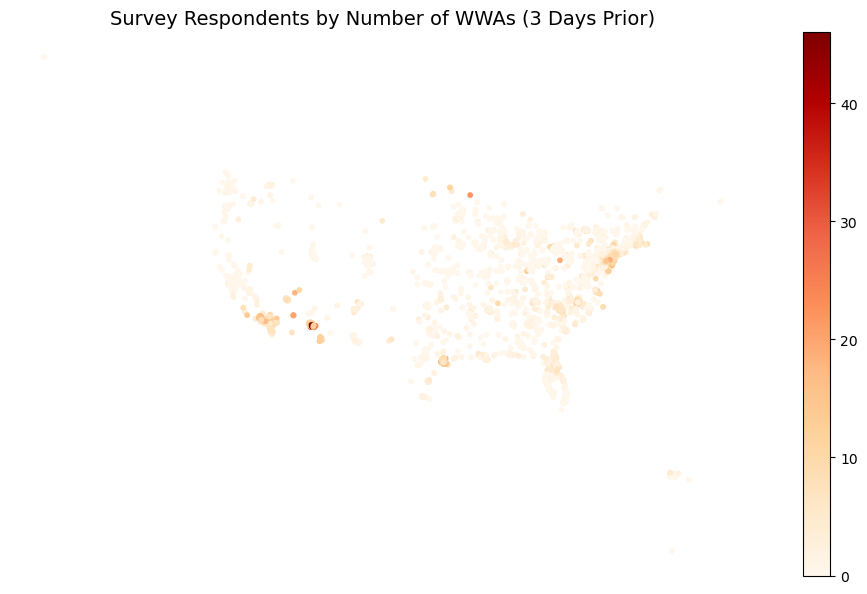

In [144]:
# Step 1: Ensure lat/lon are float (just in case)
df_18['lat'] = pd.to_numeric(df_18['lat'], errors='coerce')
df_18['lon'] = pd.to_numeric(df_18['lon'], errors='coerce')

# Step 2: Create geometry from lat/lon
geometry = [Point(xy) for xy in zip(df_18['lon'], df_18['lat'])]
gdf_18 = gpd.GeoDataFrame(df_18, geometry=geometry, crs="EPSG:4326")

# Step 3: Count WWAs
gdf_18['wwa_count'] = gdf_18['wwa_names'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Step 4: Plot
fig, ax = plt.subplots(figsize=(10, 6))
gdf_18.plot(column='wwa_count', cmap='OrRd', legend=True, ax=ax, markersize=10)
ax.set_title("Survey Respondents by Number of WWAs (3 Days Prior)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

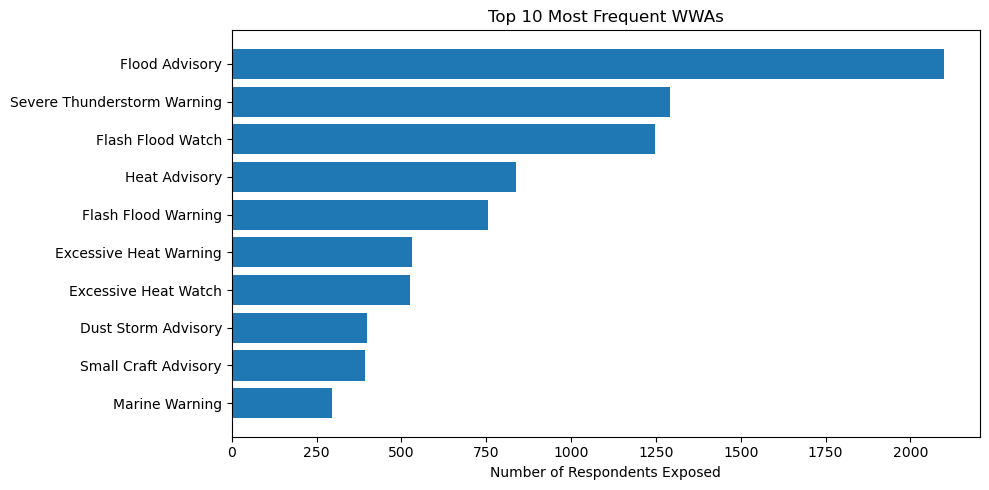

In [146]:
# Flatten and count
all_names = df_18['wwa_names'].dropna().explode()
top_names = Counter(all_names).most_common(10)

# Plot
names, counts = zip(*top_names)
plt.figure(figsize=(10, 5))
plt.barh(names[::-1], counts[::-1])
plt.title("Top 10 Most Frequent WWAs")
plt.xlabel("Number of Respondents Exposed")
plt.tight_layout()
plt.show()

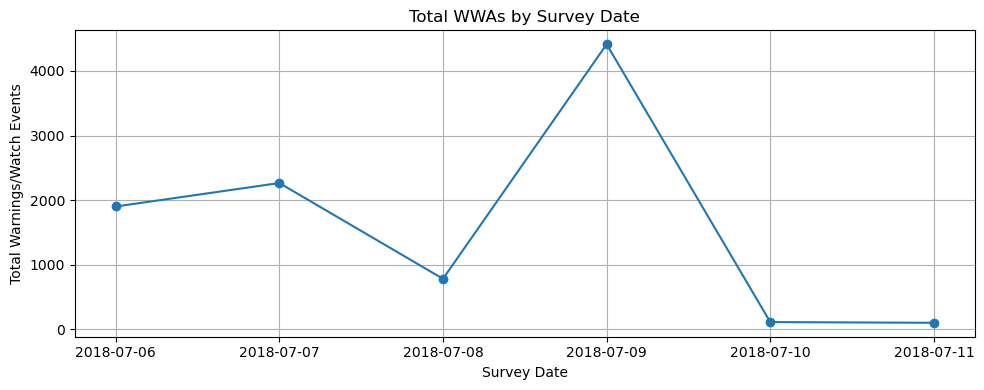

In [148]:
# Count WWAs per date
timeline = (
    df_18[['begin_date', 'wwa_names']]
    .dropna()
    .assign(wwa_count=lambda df: df['wwa_names'].apply(len))
    .groupby('begin_date')['wwa_count']
    .sum()
)

# Plot
timeline.plot(marker='o', figsize=(10, 4), title='Total WWAs by Survey Date')
plt.ylabel('Total Warnings/Watch Events')
plt.xlabel('Survey Date')
plt.grid(True)
plt.tight_layout()
plt.show()

### Visualizing WWWAs by Survey Reponses

For a next step, we might do some quick analyses/visualizations of WWAs by survey response.  Perhaps even make an interactive version with a dropdown of survey responses that a user can play with?

Let's say we want to examine how the presence of recent NWS advisories (3 days prior to taking the survey) correlates with survey respondents' perceived risk of that hazard.  How can we do that?

Step 1.  Create two groups of respondents, those experienced a WWA prior to the survey and those who did not.
Step 2.  Extract risk perception scores for a hazard (For risk_flood: 1-No risk, 2-Low Risk.....5-Extreme risk)
Step 3.  Create comparative visualizations

For these visualizations, we will focus on exposure to flood watches and warnings.

In [151]:
# --- Prep: robust WWA exposure + ordered risk labels ---

# 1) robust flood_wwa_exposure (handles NaN/non-lists)
flood_wwa_keywords = ['Flood Advisory', 'Flood Warning', 'Flash Flood Warning', 'Flash Flood Watch', 'Flood Watch']

def has_flood_wwa(wwas):
    if isinstance(wwas, (list, tuple, set)):
        return any(k in wwas for k in flood_wwa_keywords)
    return False

df_18['flood_wwa_exposure'] = df_18['wwa_names'].apply(has_flood_wwa)

# 2) numeric -> labeled flood risk (ordered categorical)
label_map = {1: 'No risk', 2: 'Low risk', 3: 'Moderate risk', 4: 'High risk', 5: 'Extreme risk'}
ordered_risk_labels = list(label_map.values())

# Coerce to numeric, map to labels, and set categorical order
df_18['risk_flood_num'] = pd.to_numeric(df_18.get('risk_flood'), errors='coerce')
df_18['risk_flood_label'] = pd.Categorical(
    df_18['risk_flood_num'].map(label_map),
    categories=ordered_risk_labels,
    ordered=True
)

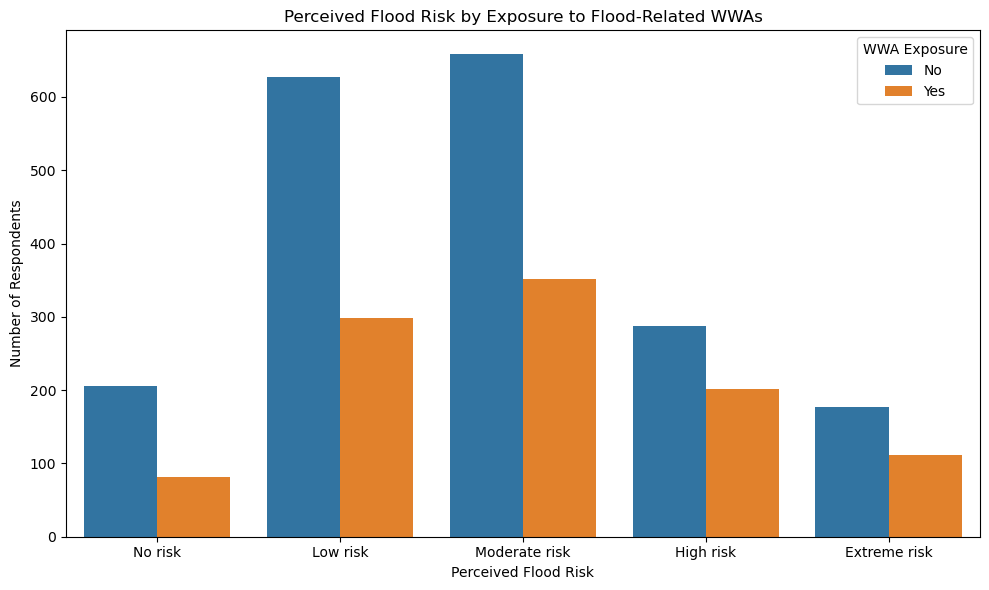

In [153]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df_18,
    x='risk_flood_label',
    hue='flood_wwa_exposure',
    order=ordered_risk_labels,
    hue_order=[False, True]
)

plt.xlabel("Perceived Flood Risk")
plt.ylabel("Number of Respondents")
plt.title("Perceived Flood Risk by Exposure to Flood-Related WWAs")
plt.legend(title="WWA Exposure", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

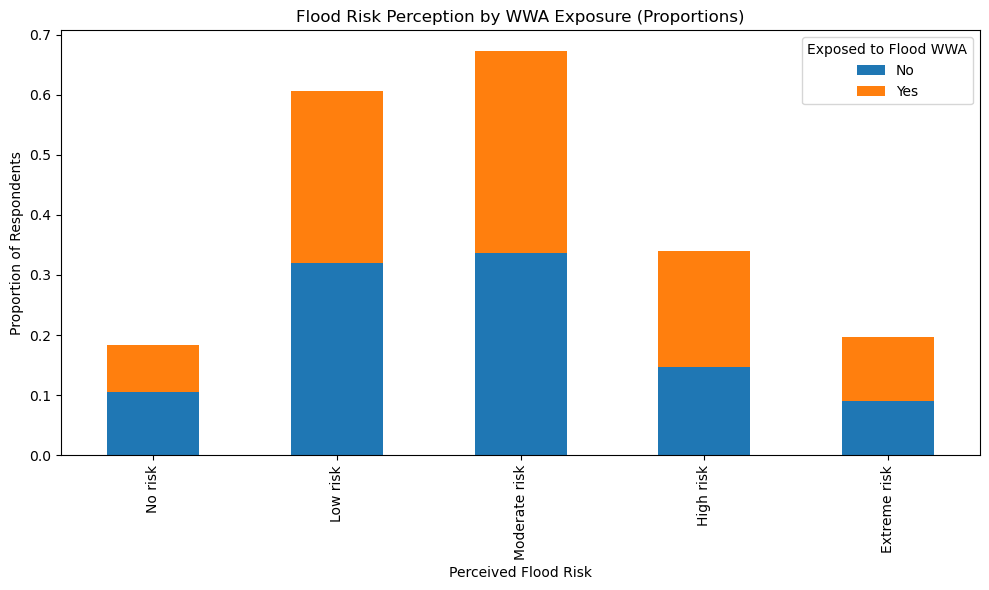

In [155]:
# crosstab -> proportions by exposure
crosstab = pd.crosstab(
    df_18['flood_wwa_exposure'],
    df_18['risk_flood_label'],
    normalize='index'
)

# ensure consistent order of rows/columns even if some levels are missing
crosstab = crosstab.reindex(index=[False, True], columns=ordered_risk_labels)

ax = crosstab.T.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

plt.title('Flood Risk Perception by WWA Exposure (Proportions)')
plt.xlabel('Perceived Flood Risk')
plt.ylabel('Proportion of Respondents')
plt.legend(title='Exposed to Flood WWA', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

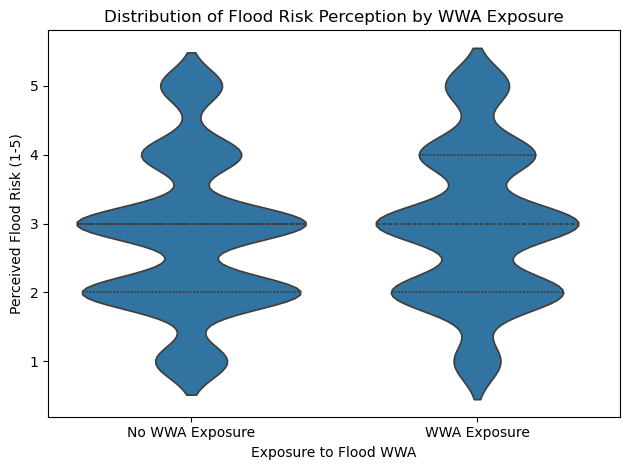

In [157]:
# I don't personally like violin plots, but let's take a look
sns.violinplot(data=df_18, x='flood_wwa_exposure', y='risk_flood', inner='quartile')
plt.xticks([0, 1], ['No WWA Exposure', 'WWA Exposure'])
plt.xlabel("Exposure to Flood WWA")
plt.ylabel("Perceived Flood Risk (1-5)")
plt.title("Distribution of Flood Risk Perception by WWA Exposure")
plt.tight_layout()
plt.show()

## Quick Statistical Analyses

We're not limited to visualizations, we can explore a number of statistical procedures to really test our question of whether exposure to warnings and watches has an impact on survey responses.  For this tutorial, we will quickly conduct the following:

1. Chi-Square: To evaluate whether exposure to flood-related warnings and watches and perceived flood risk categories are independent, with the p-value indicating if the observed relationship is statistically significant.
2. Logistic Regression: To evaluate whether exposure to flood-related warnings and watches increases the odds of respondents reporting high or extreme flood risk compared to lower risk levels.
3. Ordinal Logistic Regression: To evaluate whether exposure to flood-related warnings and watches shifts respondents toward higher categories of perceived flood risk.

### Chi-Square

In [161]:
# contingency table: WWA exposure vs. risk perception
contingency = pd.crosstab(df_18['flood_wwa_exposure'], df_18['risk_flood_label'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square test")
print(f"Chi2 = {chi2:.2f}, df = {dof}, p = {p:.4f}")

Chi-square test
Chi2 = 18.94, df = 4, p = 0.0008


This suggests that the distribution of flood risk perceptions is not independent of WWA exposure — in other words, people who were exposed to flood-related WWAs responded differently (in terms of risk levels) than those who were not exposed.

### Logistic Regression

In [165]:
# Binary outcome: high risk (≥4) vs. lower
df_18['high_risk'] = df_18['risk_flood_num'] >= 4

# Predictor: WWA exposure (cast to int)
X = sm.add_constant(df_18['flood_wwa_exposure'].astype(int))
y = df_18['high_risk'].astype(int)

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.569753
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              high_risk   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2998
Method:                           MLE   Df Model:                            1
Date:                Fri, 29 Aug 2025   Pseudo R-squ.:                0.003943
Time:                        12:03:53   Log-Likelihood:                -1709.3
converged:                       True   LL-Null:                       -1716.0
Covariance Type:            nonrobust   LLR p-value:                 0.0002343
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.1673      0.053    -21.959      0.000      -1.272      -1.063
flood

This suggests that respondents exposed to a flood WWA had significantly higher odds (about 39% greater, exp(0.3326) ≈ 1.39) of reporting high or extreme flood risk compared to those not exposed, though the overall model explains only a small share of variation in responses.

### Ordinal Logistic Regression

In [169]:
# Drop NaNs to avoid issues
df_ord = df_18.dropna(subset=['risk_flood_num', 'flood_wwa_exposure'])

# Predictor must be numeric (int)
X = df_ord[['flood_wwa_exposure']].astype(int)

# Outcome is ordered categories (numeric risk levels already ordered 1–5)
y = df_ord['risk_flood_num']

# Fit ordinal logistic regression
mod = OrderedModel(y, X, distr='logit')
res = mod.fit(method='bfgs')

print(res.summary())

Optimization terminated successfully.
         Current function value: 1.471757
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:         risk_flood_num   Log-Likelihood:                -4415.3
Model:                   OrderedModel   AIC:                             8841.
Method:            Maximum Likelihood   BIC:                             8871.
Date:                Fri, 29 Aug 2025                                         
Time:                        12:03:57                                         
No. Observations:                3000                                         
Df Residuals:                    2995                                         
Df Model:                           1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

This suggests that respondents exposed to flood-related warnings and watches had a significantly higher likelihood of placing themselves in higher flood risk perception categories (coef = 0.296, p < 0.001), indicating a consistent upward shift in perceived risk.

## A Bit More Involved - Did WWAs *Really* Affect Risk Perception?

So it appears that exposure to watches and warnings has a statistically significant impact on survey responses.  But by how much? To answer this, we can look at the **predicted probabilities** of survey responses.  This shows us how much exposure to a WWA changes the likelihood of a respondent reporting “High” or “Extreme” flood risk.  

To do this, the code below creates two simple scenarios: one where a person had no flood alert (0) and one where they did (1).  It then uses our statistical model to predict the probability of each risk category under those two scenarios.  The results are labeled clearly as “No Exposure” and “Exposure,” giving us a side-by-side view.  

**Analogy:** It’s like asking, “What would the risk look like if nobody had a flood alert?” and then,  “What would the risk look like if everyone had a flood alert?” — and comparing the two answers side by side.  


In [173]:
# Make two scenarios: no exposure (0) and exposure (1)
scenarios = pd.DataFrame({
    'flood_wwa_exposure': [0, 1]
})

# Predict probabilities for each risk category
pred_probs = res.predict(scenarios)

# Attach labels
pred_probs.index = ['No Exposure', 'Exposure']
pred_probs.columns = [f"Risk {c}" for c in pred_probs.columns]

pred_probs


,Risk 0,Risk 1,Risk 2,Risk 3,Risk 4
No Exposure,0.103841,0.323847,0.332512,0.152608,0.087192
Exposure,0.080450,0.280261,0.344614,0.182370,0.112304


## A possible interpretation

Respondents who were exposed to a flood WWA were less likely to report no risk (10% → 8%) or low risk (32% → 28%), and more likely to report higher levels of risk perception, particularly at the “High” (15% → 18%) and “Extreme” (9% → 11%) categories. While the percentage point changes may look modest, they indicate a clear upward shift in perceived flood risk among those who received WWAs.  In other words, I think it is possible to say that exposure to a flood warning nudged people away from saying ‘no risk’ and toward saying ‘high or extreme risk.  However, with only 3,000 responses, I probably wouldn't.  But, as the academics say, this requires further study. 😉

Now let's take a look at a visualization of these results.

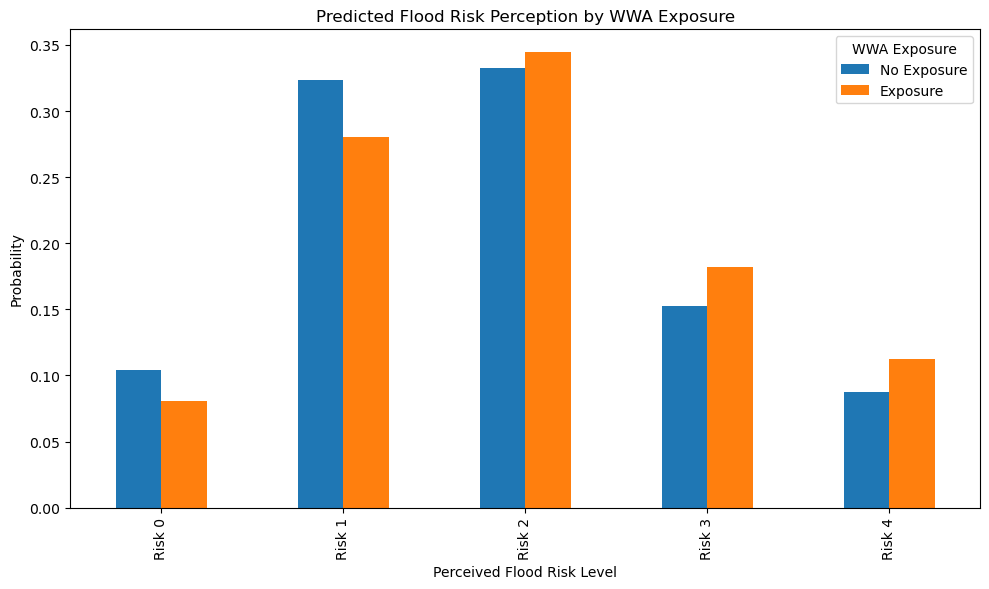

In [176]:
#let's see HOW the probability distribution shift
ax = pred_probs.T.plot(kind='bar', figsize=(10,6))
plt.title("Predicted Flood Risk Perception by WWA Exposure")
plt.ylabel("Probability")
plt.xlabel("Perceived Flood Risk Level")
plt.legend(title="WWA Exposure")
plt.tight_layout()
plt.show()

## Wrapping Up

In this tutorial, we explored how to bring together **social survey data** and **weather warning data** to better understand how hazard information influences perceptions of risk. Using the Jupyter Notebook environment, you learned how to:  

- **Work with APIs** to search for, access, and download data programmatically  
- Organize and explore datasets interactively using python libraries like **pandas** and **requests**.  
- Merge survey data with external data from the **Iowa Environmental Mesonet**  
- Apply **geospatial tools** to handle location-based data  
- Create clear, reproducible **visualizations** and **statistical analyses** directly alongside your analysis  
- Document your process in a way that combines code, results, and explanation all in one place  

With this walkthrough, you’ve seen how Jupyter can serve as both a **research lab and a communication tool**—a space where you can work with data, analyze the data, visualize the data and results, and explain what you found.  

### Moving Forward  
- Try adapting this workflow to other survey topics (e.g., heat, drought, tornado risk)  
- Explore additional Mesonet or NOAA APIs to enrich your analysis with different kinds of data  
- Use Jupyter notebooks to build **reproducible reports**, where readers can see not just your conclusions but also the steps you took to get there  
- Share your notebooks with collaborators as a way to make your analysis **transparent and interactive**  

Ultimately, the key takeaway is that with just a few tools—**APIs, pandas, geospatial libraries, and Jupyter notebooks**—you can connect diverse datasets, analyze them in context, and tell meaningful data stories about risk and society.  

---

**Thank you for following along!**  
We encourage you to take this workflow and apply it to your own research questions about weather, risk, and society—the more you explore, the more insights you’ll uncover.  
